In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("../..")

In [2]:
%load_ext autoreload
%autoreload 2
import penzai
import jax_smi
jax_smi.initialise_tracking()
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained("models/gemma-2b-it.gguf", from_type="gemma", load_eager=True, device_map="tpu:0")

In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("alpindale/gemma-2b")
tokenizer.padding_side = "right"

In [5]:
from sprint.icl_sfc_utils import Circuitizer

In [6]:
from sprint.task_vector_utils import load_tasks, ICLRunner
tasks = load_tasks()

In [7]:
# task_names = ["en_es", "antonyms", "person_profession", "es_en", "present_simple_gerund", "present_simple_past_simple", "person_profession", "person_language", "country_capital", "football_player_position"]
# task_name = task_names[1]
task_names = list(tasks.keys())

In [8]:
import json

with open("cleanup_results.jsonl") as f:
    lines = f.readlines()
    results = [json.loads(line) for line in lines]

In [9]:
import jax.numpy as jnp
import jax


from sprint.task_vector_utils import ICLRunner, logprob_loss, get_tv, make_act_adder
from micrlhf.llama import LlamaBlock
from micrlhf.sampling import sample, jit_wrapper


get_resids = llama.select().at_instances_of(LlamaBlock).apply_with_selected_index(lambda i, x:
    pz.nn.Sequential([
        pz.de.TellIntermediate.from_config(tag=f"resid_pre_{i}"),
        x
    ])
)
get_resids = pz.de.CollectingSideOutputs.handling(get_resids, tag_predicate=lambda x: x.startswith("resid_pre"))
get_resids_call = jit_wrapper.Jitted(get_resids)



def tokenized_to_inputs(input_ids, attention_mask):
    token_array = jnp.asarray(input_ids)
    token_array = jax.device_put(token_array, jax.sharding.NamedSharding(llama.mesh, jax.sharding.PartitionSpec("dp", "sp")))
    token_array = pz.nx.wrap(token_array, "batch", "seq").untag("batch").tag("batch")

    mask_array = jnp.asarray(attention_mask, dtype=jnp.bool)
    mask_array = jax.device_put(mask_array, jax.sharding.NamedSharding(llama.mesh, jax.sharding.PartitionSpec("dp", "sp")))
    mask_array = pz.nx.wrap(mask_array, "batch", "seq").untag("batch").tag("batch")

    inputs = llama.inputs.from_basic_segments(token_array)
    return inputs


In [23]:
from sprint.icl_sfc_utils import AblatedModule
layer = 14
mask_name = "arrow"

In [11]:
import numpy as np

features = []

for task_name in task_names:
    task_results = [result for result in results if result["task"] == task_name and result["layer"] == layer]

    for result in task_results:
        w = np.array(result["weights"])
        w = w * (w > 0)

        features += np.nonzero(w)[0].tolist()

features = list(set(features))

len(features)

43

In [24]:
task_names = ["antonyms", "en_es", "es_en", "present_simple_gerund", "country_capital", "en_fr", "en_it", "fr_en"]


features = []

for task_name in task_names:


    
    with open(f"micrlhf-progress/all-graph-{task_name}-fixed.json") as f:
        graph = json.load(f)

    nodes = graph["nodes"]

    nodes = [node for node in nodes if node[1] == layer and node[0] == "r" and node[2] == "arrow"]
    
    features += [node[3] for node in nodes[:10]]

features = list(set(features))
len(features)

42

In [25]:
from micrlhf.utils.load_sae import get_nev_it_sae_suite


sae = get_nev_it_sae_suite(layer=layer)

In [ ]:
from tqdm.auto import tqdm

task_losses = {}

n_few_shots, batch_size, max_seq_len = 20, 16, 256
seed = 10

prompt = "Follow the pattern:\n{}"


for task_name in tqdm(task_names):

    sep = 3978
    pad = 0


    pairs = list(tasks[task_name].items())

    runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=n_few_shots-1, max_seq_len=max_seq_len, seed=seed, prompt=prompt)

    tokenized = runner.get_tokens([
        x[:n_few_shots] for x in runner.train_pairs
    ], tokenizer)

    inputs = tokenized_to_inputs(**tokenized)
    train_tokens = tokenized["input_ids"]

    _, all_resids = get_resids_call(inputs)

    def steer_with_direction(direction, scale):
        direction = direction / jnp.linalg.norm(direction)
        direction = direction * scale
        add_act = make_act_adder(llama, direction, train_tokens, 12, sep=sep)

        logits = add_act(inputs)
        logits = logits.unwrap("batch", "seq", "vocabulary")

        return logprob_loss(logits, train_tokens, sep=sep, pad_token=pad, n_first=2)

    task_losses[task_name] = [[steer_with_direction(-sae["W_dec"][feature], 33).tolist() for feature in tqdm(features)]]

    logits = llama(inputs)

    logits = logits.unwrap("batch", "seq", "vocabulary")

    task_losses[task_name].append(logprob_loss(logits, train_tokens, sep=sep, pad_token=pad, n_first=2).tolist())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

In [15]:
from tqdm.auto import tqdm
from functools import partial
from micrlhf.utils.activation_manipulation import add_vector

task_losses = {}

n_few_shots, batch_size, max_seq_len = 20, 16, 256
seed = 10

prompt = "Follow the pattern:\n{}"


for task_name in tqdm(task_names):

    sep = 3978
    pad = 0


    pairs = list(tasks[task_name].items())
    
    runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=1, max_seq_len=max_seq_len, seed=seed, prompt=prompt)

    tokenized = runner.get_tokens([
        x[:n_few_shots] for x in runner.train_pairs
    ], tokenizer)

    inputs = tokenized_to_inputs(**tokenized)
    train_tokens = tokenized["input_ids"]

    _, all_resids = get_resids_call(inputs)

    scale = 23
    
    def steer_with_direction(direction):
        direction = direction / jnp.linalg.norm(direction)
        direction = direction * scale
        
        mask = train_tokens == sep

        col_indices = jnp.arange(mask.shape[1])

        col_indices_broadcasted = mask * col_indices

        sorted_indices = jnp.sort(col_indices_broadcasted, axis=1, descending=True)

        positions = sorted_indices[:, :1]

        add_act = add_vector(llama, direction, layer, 1, position = positions)

        logits = add_act(inputs)
        logits = logits.unwrap("batch", "seq", "vocabulary")

        return logprob_loss(logits, train_tokens, sep=sep, pad_token=pad, n_first=3)

    task_losses[task_name] = [[steer_with_direction(sae["W_dec"][feature]).tolist() for feature in tqdm(features)]]

    logits = llama(inputs)

    logits = logits.unwrap("batch", "seq", "vocabulary")

    task_losses[task_name].append(logprob_loss(logits, train_tokens, sep=sep, pad_token=pad, n_first=3).tolist())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

In [26]:
import dataclasses
from tqdm.auto import tqdm
from functools import partial
from micrlhf.utils.activation_manipulation import add_vector

negative_task_losses = {}

n_few_shots, batch_size, max_seq_len = 20, 16, 256
seed = 10

prompt = "Follow the pattern:\n{}"

def calc_acc(tokens, sep, logits, runner):
    arrow_pos = jnp.nonzero(tokens == sep)
    arrow_pos_single = []
    for i in range(batch_size):
        arrow_pos_single.append(arrow_pos[1][arrow_pos[0] == i].max())

    arrow_pos_single = np.array(arrow_pos_single)

    hits = 0

    for i, (ap, l) in enumerate(zip(arrow_pos_single, logits)):
        l = l.argmax(-1)
        tgt = runner.eval_pairs[i][-1][1]
        hits += int(tgt in repr(tokenizer.decode(l[ap:ap+3])))
    return hits / runner.eval_batch_size

def calc_acc(tokens, sep, logits, runner):
    logits = logits.argmax(-1)
    logits = logits[:, :-1]
    tokens = tokens[:, 1:]

    mask = tokens == sep

    hits = tokens == logits

    hits = hits * mask

    hits = hits.sum()
    return hits / mask.sum()




def make_taker(llama, layer):
    taker = jit_wrapper.Jitted(llama.select().at_instances_of(LlamaBlock).apply_with_selected_index(
        lambda i, x: x if i >= layer else pz.nn.Identity()
    ).select().at_instances_of(pz.nn.EmbeddingLookup).apply(lambda _: pz.nn.Identity())
                    .select().at_instances_of(pz.nn.ConstantRescale).pick_nth_selected(0).apply(lambda _: pz.nn.Identity()))

    return taker

taker = make_taker(llama, layer)

for task_name in tqdm(task_names):

    sep = 3978
    pad = 0


    pairs = list(tasks[task_name].items())

    n_shot = n_few_shots - 1
    if task_name.startswith("algo"):
        n_shot = 16

    runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=n_shot, max_seq_len=max_seq_len, seed=seed, prompt=prompt)

    tokenized = runner.get_tokens([
        x[:n_few_shots] for x in runner.train_pairs
    ], tokenizer)

    inputs = tokenized_to_inputs(**tokenized)
    train_tokens = tokenized["input_ids"]

    _, all_resids = get_resids_call(inputs)

    scale = 30

    resids = all_resids[layer].value.unwrap("batch", "seq", "embedding")

    mask = train_tokens == sep
    col_indices = jnp.arange(mask.shape[1])
    col_indices_broadcasted = mask * col_indices
    sorted_indices = jnp.sort(col_indices_broadcasted, axis=1, descending=True)

    k = jnp.sum(mask[0]).astype(int)

    positions = sorted_indices[:, :k]
    
    def steer_with_direction(direction):
        direction = direction / jnp.linalg.norm(direction)
        direction = direction * scale
        
        modified = jax.vmap(lambda a, b: a.at[b].add(direction))(
            resids, positions
        )
        modified = pz.nx.wrap(modified, "batch", "seq", "embedding")

        _inputs = dataclasses.replace(inputs, tokens=modified)
        logits = taker(_inputs).unwrap("batch", "seq", "vocabulary")

        acc = calc_acc(train_tokens, sep, logits, runner)

        return logprob_loss(logits, train_tokens, sep=sep, pad_token=pad, n_first=2), acc

    negative_task_losses[task_name] = [[steer_with_direction(-sae["W_dec"][feature]) for feature in tqdm(features)]]

    logits = llama(inputs)

    logits = logits.unwrap("batch", "seq", "vocabulary")

    acc = calc_acc(train_tokens, sep, logits, runner)
    negative_task_losses[task_name].append((logprob_loss(logits, train_tokens, sep=sep, pad_token=pad, n_first=2), acc))

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

In [17]:
import plotly.express as px
import pandas as pd
import numpy as np

normalized_losses = {}

for task_name, losses in task_losses.items():
    base_loss = losses[1]
    losses = losses[0]
    mean_loss = np.mean(losses)

    normalized_losses[task_name] = [(loss - base_loss) / base_loss for loss in losses]


df = pd.DataFrame([
    {"task": task_name, "feature": feature, "loss": loss}
    for task_name, losses in normalized_losses.items()
    for feature, loss in zip(features, losses)
])



heatmap = np.zeros((len(task_names), len(features)))

for i, task_name in enumerate(task_names):
    for j, feature in enumerate(features):
        heatmap[i, j] = normalized_losses[task_name][j]

fig = px.imshow(heatmap, x=[str(x) for x in features], y=task_names, zmax=1, zmin=-1)

fig.show()


In [28]:
import plotly.express as px
import pandas as pd
import numpy as np

normalized_losses = {}

# drop_features = [55186, 18719]
drop_features = []
drop_ids = [features.index(feature) for feature in drop_features]

features_dropped = [feature for feature in features if feature not in drop_features]

for task_name, losses in negative_task_losses.items():
    base_loss = losses[1]
    losses = [x[0].tolist() for x in losses[0]]
    losses = np.array(losses)
    losses = np.delete(losses, drop_ids)

    losses = losses - base_loss[0]
    
    max_loss = np.max(losses)
    min_loss = np.min(losses)

    losses = (losses - min_loss) / (max_loss - min_loss)
    
    # mean_loss = np.mean(losses - base_loss)

    # base_acc = losses[1][1]

    # accs = [base_acc - loss[1] for loss in losses[0]]
    normalized_losses[task_name] = losses


heatmap = np.zeros((len(task_names), len(features_dropped)))

for i, task_name in enumerate(task_names):
    for j, feature in enumerate(features_dropped):
        heatmap[i, j] = normalized_losses[task_name][j]

heatmap /= np.mean(heatmap, axis=0, keepdims=True)



# heatmap = np.where(heatmap > 0, np.log(heatmap), -10)
# heatmap[np.isnan(heatmap)] = np.min(heatmap[np.isfinite(heatmap)])
# heatmap[np.isinf(heatmap)] = np.max(heatmap[np.isfinite(heatmap)])

# heatmap = np.clip(heatmap, -5, 5)


fig = px.imshow(heatmap, x=[str(x) for x in features_dropped], y=task_names, title=f"Negative steering effect (Gemma 1, L{layer}, sfc top 10)")

fig.show()


In [61]:
task_losses[task_name][0]

[-3.484848484848485,
 -0.15656565656565657,
 -3.202020202020202,
 -0.3434343434343434,
 -0.7171717171717171,
 -0.2676767676767677,
 -0.696969696969697,
 -1.4646464646464648,
 -0.30303030303030304,
 -0.7070707070707071,
 -1.9090909090909092]

In [66]:
import plotly.express as px
import pandas as pd
import numpy as np

for task_name, losses in task_losses.items():
    base_loss = losses[1]
    losses = losses[0]

    task_losses[task_name][0] = [(base_loss - loss) for loss in losses]


df = pd.DataFrame([
    {"task": task_name, "feature": feature, "loss": loss}
    for task_name, losses in task_losses.items()
    for feature, loss in zip(features, losses[0])
])



heatmap = np.zeros((len(task_names), len(features)))

for i, task_name in enumerate(task_names):
    for j, feature in enumerate(features):
        heatmap[i, j] = task_losses[task_name][0][j]

fig = px.imshow(heatmap, x=[str(x) for x in features], y=task_names)

fig.show()


In [64]:
import plotly.express as px
import pandas as pd
import numpy as np

for task_name, losses in task_losses.items():
    base_loss = losses[1]
    losses = losses[0]

    task_losses[task_name][0] = [(base_loss - loss) for loss in losses]


df = pd.DataFrame([
    {"task": task_name, "feature": feature, "loss": loss}
    for task_name, losses in task_losses.items()
    for feature, loss in zip(features, losses[0])
])



heatmap = np.zeros((len(task_names), len(features)))

for i, task_name in enumerate(task_names):
    for j, feature in enumerate(features):
        heatmap[i, j] = task_losses[task_name][0][j]

fig = px.imshow(heatmap, x=[str(x) for x in features], y=task_names)

fig.show()


In [73]:
import plotly.express as px
import pandas as pd
import numpy as np

for task_name, losses in task_losses.items():
    base_loss = losses[1]
    losses = losses[0]

    task_losses[task_name][0] = [(base_loss - loss) for loss in losses]


df = pd.DataFrame([
    {"task": task_name, "feature": feature, "loss": loss}
    for task_name, losses in task_losses.items()
    for feature, loss in zip(features, losses[0])
])



heatmap = np.zeros((len(task_names), len(features)))

for i, task_name in enumerate(task_names):
    for j, feature in enumerate(features):
        heatmap[i, j] = task_losses[task_name][0][j]

fig = px.imshow(heatmap, x=[str(x) for x in features], y=task_names)

fig.show()


In [75]:
import plotly.express as px
import pandas as pd
import numpy as np

for task_name, losses in task_losses.items():
    base_loss = losses[1]
    losses = losses[0]

    task_losses[task_name][0] = [(base_loss - loss) for loss in losses]


df = pd.DataFrame([
    {"task": task_name, "feature": feature, "loss": loss}
    for task_name, losses in task_losses.items()
    for feature, loss in zip(features, losses[0])
])



heatmap = np.zeros((len(task_names), len(features)))

for i, task_name in enumerate(task_names):
    for j, feature in enumerate(features):
        heatmap[i, j] = task_losses[task_name][0][j]

fig = px.imshow(heatmap, x=[str(x) for x in features], y=task_names)

fig.show()


In [77]:
import plotly.express as px
import pandas as pd
import numpy as np

for task_name, losses in task_losses.items():
    base_loss = losses[1]
    losses = losses[0]

    task_losses[task_name][0] = [(base_loss - loss) for loss in losses]


df = pd.DataFrame([
    {"task": task_name, "feature": feature, "loss": loss}
    for task_name, losses in task_losses.items()
    for feature, loss in zip(features, losses[0])
])



heatmap = np.zeros((len(task_names), len(features)))

for i, task_name in enumerate(task_names):
    for j, feature in enumerate(features):
        heatmap[i, j] = task_losses[task_name][0][j]

fig = px.imshow(heatmap, x=[str(x) for x in features], y=task_names)

fig.show()


In [46]:
feature = 11618

direction = sae["W_dec"][feature]


def steer_with_direction(direction, scale):
    direction = direction / jnp.linalg.norm(direction)
    direction = direction * scale
    add_act = make_act_adder(llama, direction, train_tokens, 12, sep=sep)

    logits = add_act(inputs)
    logits = logits.unwrap("batch", "seq", "vocabulary")

    return logprob_loss(logits, train_tokens, sep=sep, pad_token=pad, n_first=2)

In [38]:
import numpy as np
from tqdm.auto import tqdm

scales = np.linspace(0, 100, 30)

losses = [steer_with_direction(-direction, scale) for scale in tqdm(scales)]

  0%|          | 0/30 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promot

[<matplotlib.lines.Line2D at 0x7f0b30b1ee90>]

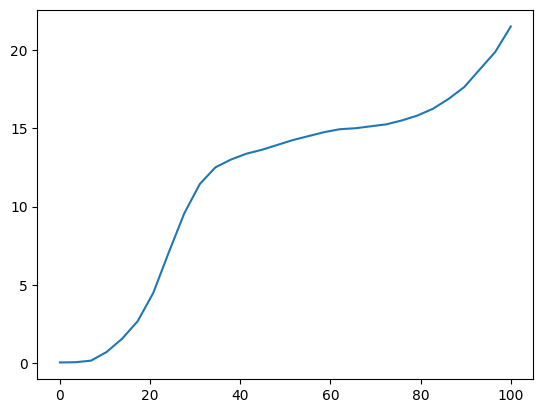

In [40]:
import matplotlib.pyplot as plt

losses = [x.tolist() for x in losses]

plt.plot(scales, losses)

In [47]:
losses_features = [steer_with_direction(-sae["W_dec"][feature], 30).tolist() for feature in tqdm(features)]

  0%|          | 0/11 [00:00<?, ?it/s]

In [42]:
losses_features

[3.65625,
 0.3046875,
 0.84765625,
 5.78125,
 8.1875,
 2.59375,
 11.0,
 7.03125,
 1.0390625,
 1.6640625,
 5.4375]

In [48]:
losses_features

[4.25,
 1.2578125,
 2.15625,
 4.84375,
 6.03125,
 3.84375,
 9.5625,
 6.8125,
 2.703125,
 2.90625,
 6.09375]